## Circadian Logistic Regression for Early Seizure Detection
Based on the following work:
> Philippa J Karoly, Hoameng Ung, David B Grayden, Levin Kuhlmann, Kent Leyde, Mark J Cook, Dean R Freestone, The circadian profile of epilepsy improves seizure forecasting, Brain, Volume 140, Issue 8, August 2017, Pages 2169–2182, https://doi.org/10.1093/brain/awx173

## Imports

In [2]:
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from ieeg.auth import Session
from ieeg.dataset import Dataset
import warnings

from msc import config
from msc.config import get_authentication

plt.style.use(['science', 'no-latex'])
matplotlib.rcParams['figure.figsize'] = (6.4, 4.8)

%load_ext autoreload
%autoreload 2

In [3]:
SEC = 1e6
MIN = 60 * SEC
HOUR = 60 * MIN

## Get data

### Connect to dataset

In [4]:
dataset_name = 'I004_A0003_D001'  # from ieeg.org portal
username, password = get_authentication()  # to access ieeg.org portal
s = Session(username, password)  # start streaming session
ds = s.open_dataset(dataset_name)  # open dataset stream
ch_names = ds.get_channel_labels()  # get channel names
for ch_name in ch_names:    # describe dataset
    print(ds.get_time_series_details(ch_name))

chan name(LEFT_01) spans 41102050476440.0 usec, range [-2048-2047] in 11840519700 samples. Starts @1248984678000000 uUTC, ends @1290086728476440 uUTC with sample rate 399.609756097561 Hz and voltage conv factor 1.0
chan name(LEFT_02) spans 36928828122497.0 usec, range [-2048-2047] in 10240999318 samples. Starts @1248984678000000 uUTC, ends @1285913506122497 uUTC with sample rate 399.609756097561 Hz and voltage conv factor 1.0
chan name(LEFT_03) spans 41102051622680.0 usec, range [-2027-2047] in 11840495724 samples. Starts @1248984678000000 uUTC, ends @1290086729622680 uUTC with sample rate 399.609756097561 Hz and voltage conv factor 1.0
chan name(LEFT_04) spans 41102050476440.0 usec, range [-2027-2047] in 11840519700 samples. Starts @1248984678000000 uUTC, ends @1290086728476440 uUTC with sample rate 399.609756097561 Hz and voltage conv factor 1.0
chan name(LEFT_05) spans 41102050476440.0 usec, range [-2026-2047] in 11840519700 samples. Starts @1248984678000000 uUTC, ends @129008672847

In [5]:
start_time = datetime.datetime.fromtimestamp(ds.start_time / SEC, datetime.timezone.utc)
end_time = datetime.datetime.fromtimestamp(ds.end_time / SEC, datetime.timezone.utc)
recording_length = end_time - start_time
recording_length

datetime.timedelta(days=475, seconds=62051, microseconds=622680)

### Get labels

In [6]:
seizures = ds.get_annotations('seizures')
seizure_onsets = [start_time + datetime.timedelta(microseconds=seizure.start_time_offset_usec) for seizure in seizures]
len(seizure_onsets)

45

In [7]:
seizure_onsets

[datetime.datetime(2009, 8, 13, 22, 36, 39, 606445, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 8, 14, 6, 40, 27, 926757, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 8, 14, 11, 28, 3, 761718, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 8, 14, 21, 0, 7, 248047, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 11, 22, 27, 54, 582031, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 3, 7, 1, 920898, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 7, 57, 10, 905273, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 13, 32, 34, 538086, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 17, 32, 10, 563476, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 20, 12, 0, 919922, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 12, 23, 13, 41, 554687, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 9, 13, 2, 8, 2, 760742, tzinfo=datetime.timezone.utc),
 datetime.dateti

array([[<AxesSubplot:title={'center':'hour'}>]], dtype=object)

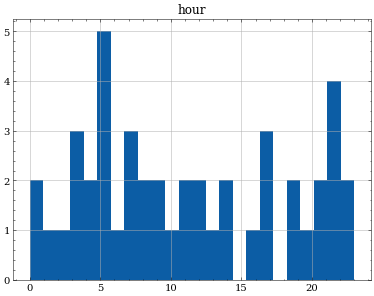

In [8]:
seizure_onsets_df = pd.DataFrame(seizure_onsets, columns=['datetime'])
seizure_onsets_df['year'] = seizure_onsets_df['datetime'].dt.year
seizure_onsets_df['month'] = seizure_onsets_df['datetime'].dt.month
seizure_onsets_df['day'] = seizure_onsets_df['datetime'].dt.day
seizure_onsets_df['hour'] = seizure_onsets_df['datetime'].dt.hour
seizure_onsets_df['minute'] = seizure_onsets_df['datetime'].dt.minute
seizure_onsets_df['second'] = seizure_onsets_df['datetime'].dt.second
seizure_onsets_df.iloc[:50].hist('hour', bins=24)

Text(0.5, 1.0, 'Hourly seizure counts')

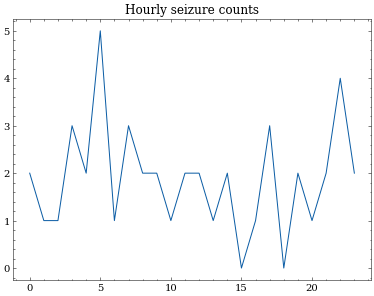

In [9]:
circadian_hist = pd.cut(seizure_onsets_df.hour, 24, labels=range(24)).value_counts().sort_index()
circadian_hist.plot()
plt.title('Hourly seizure counts')

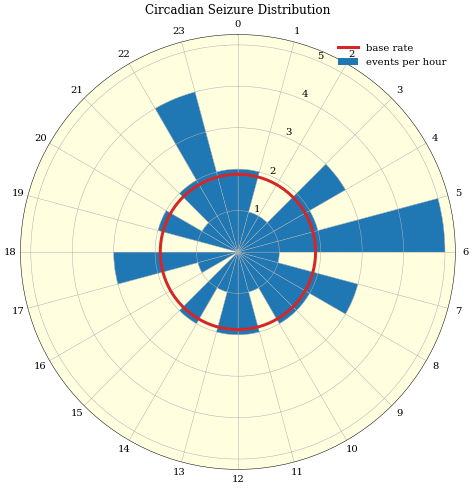

In [64]:
N = 24

# prepare figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar', facecolor='white')

# initialize seizure distribution as periodical
half_hour_offset = (1/2) * (1/N) * 2 * np.pi
theta = np.linspace(0.0 + half_hour_offset, 2 * np.pi + half_hour_offset, N, endpoint=False)
radii = circadian_hist
width = 2 * np.pi / N

# define axis
ax = plt.subplot(111, projection='polar', facecolor='lightyellow')

# plot seizures
bars = ax.bar(theta, radii, width=width, bottom=0.0, label='events per hour', color='tab:blue')

# make the labels start at North
ax.set_theta_zero_location('N')

# make the labels go clockwise
ax.set_theta_direction(-1)

# clock labels
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))

# add base rate
ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*sum(circadian_hist)/N, color='tab:red', linestyle='-', lw=3, label='base rate')

# add legend
ax.legend()
plt.title("Circadian Seizure Distribution")
plt.show()

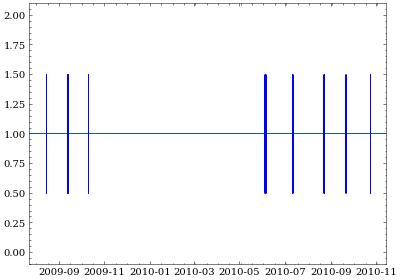

In [11]:
plt.hlines(1,0, 7*2400)
plt.eventplot(seizure_onsets, orientation='horizontal', colors='b')


In [12]:

num_channels =  len(ch_names)
windows = []
start_times = [0, 10*MIN, 20*MIN, 30*MIN, 40*MIN, 50*MIN]
for start in start_times:
    window = ds.get_data(start=0, duration=10.00*MIN, channels=np.arange(num_channels))
    windows.append(window)
data = np.stack(windows)
if np.any(np.isnan(data)):
    warnings.warn(f"error: there exist {np.count_nonzero(np.isnan(data))}/{data.size} NaN entries in data which is {100*np.count_nonzero(np.isnan(data))/data.size:.2f}%")

/tmp/ipykernel_13637/2632083923.py:9: UserWarning: error: there exist 17339136/23017536 NaN entries in data which is 75.33%
  warnings.warn(f"error: there exist {np.count_nonzero(np.isnan(data))}/{data.size} NaN entries in data which is {100*np.count_nonzero(np.isnan(data))/data.size:.2f}%")


In [13]:
data[0, :, 0].shape

(239766,)

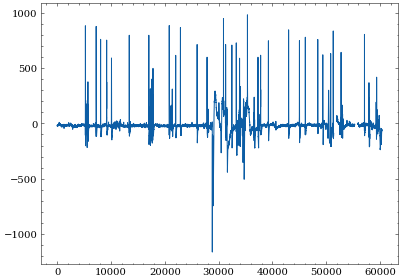

In [14]:
plt.plot(data[4, :, 0])

In [15]:
np.where(np.isnan(data[0, :, 0]))[0][:1000]

array([ 6200,  6201,  6202,  6203,  6204,  6205,  6206,  6207,  6208,
        6209,  6210,  6211,  6212,  6213,  6214,  6215,  6216,  6217,
        6218,  6219,  6220,  6221,  6222,  6223,  6224,  6225,  6226,
        6227,  6228,  6229,  6230,  6231,  6232,  6233,  6234,  6235,
        6236,  6237,  6238,  6239,  6240,  6241,  6242,  6243,  6244,
        6245,  6246,  6247,  6248,  6249,  6250,  6251,  6252,  6253,
        6254,  6255,  6256,  6257,  6258,  6259,  6260,  6261,  6262,
        6263,  6264,  6265,  6266,  6267,  6268,  6269,  6270,  6271,
        6272,  6273,  6274,  6275,  6276,  6277,  6278,  6279,  6280,
        6281,  6282,  6283,  6284,  6285,  6286,  6287,  6288,  6289,
        6290,  6291,  6292,  6293,  6294,  6295,  6296,  6297,  6298,
        6299, 51400, 51401, 51402, 51403, 51404, 51405, 51406, 51407,
       51408, 51409, 51410, 51411, 51412, 51413, 51414, 51415, 51416,
       51417, 51418, 51419, 51420, 51421, 51422, 51423, 51424, 51425,
       51426, 51427,

In [16]:
annotations = ds.get_annotations('seizures')[i]
onsets = 

SyntaxError: invalid syntax (283922401.py, line 2)

In [ ]:
plt.plot(np.sum(np.count_nonzero(np.isnan(data), axis=0), axis=1))

In [ ]:
np.count_nonzero(np.isnan(data))

In [ ]:
np.count_nonzero(~np.isnan(data))

### Get annotations

In [ ]:
ds.get_annotation_layers()

## Extract features

In [ ]:
data.shape

# Fit logistic regression

## Evaluate logistic regression classifier

## Plot circadian profile

## Define von Mises prior

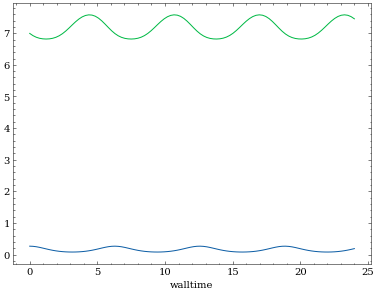

circadian_hist=0     2
1     1
2     1
3     3
4     2
5     5
6     1
7     3
8     2
9     2
10    1
11    2
12    2
13    1
14    2
15    0
16    1
17    3
18    0
19    2
20    1
21    2
22    4
23    2
Name: hour, dtype: int64


In [141]:
import numpy as np
from scipy.special import i0
from functools import partial
N = 24
def vmdensity(x, mu=0, k=0.6):
    return np.exp(k * np.cos(x - mu))/(2 * np.pi * i0(k))

X = np.linspace(0, 24, 100)
y = vmdensity(X)
weights = np.ones(N)
# weights[5] = 10
# weights[2] = 10
mus = np.arange(N) + 0.5
weights[21:] = 0
def mixture(x):
    return sum([circadian_hist[i] * partial(vmdensity, mu=mu)(x) for i, mu in enumerate(mus)])
plt.plot(X, y)
plt.plot(X, mixture(X))
plt.xlabel('walltime')
# plt.xlim(0, 100)
plt.show()
print(f"{circadian_hist=}")

In [77]:
partial(vmdensity, mu=2)(x)

NameError: name 'x' is not defined

## Evaluate circadian logistic regression

Concluding remarks